## Introduction

Problem Statement:
* The Online Retail dataset encompasses transactions from a UK-based online retailer between 01/12/2009 and 09/12/2011.
* The goal is to extract actionable insights to optimize customer retention, improve sales strategies, and enhance business performance.

Objectives:
1. Understand the customer base through segmentation and behavior analysis.
2. Identify key trends and patterns in sales data over time.
3. Recommend strategies to improve customer experience and boost revenue.


## Load and Preprocessing Data

In [ ]:
! python --version

Python 3.10.12


In [ ]:
pip install ucimlrepo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# fetch dataset
online_retail = fetch_ucirepo(id=352)

# metadata
print(online_retail.metadata)

# variable information
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [ ]:
# convert the fetch dataset into dataframe format to make it easy to analyze
data_url = online_retail.metadata['data_url']
df = pd.read_csv(data_url)

# display the first few rows of the DataFrame
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [ ]:
# check the data type and other information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Handling Data Quality

In [ ]:
# check null values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
# drop null rows where CustomerID or Description have null value
df = df.dropna(subset=['CustomerID', 'Description'])

# drop duplicated rows
df = df.drop_duplicates()

# separate canceled orders
df['IsCanceled'] = df['InvoiceNo'].str.contains('C', na=False)

# convert data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('float')

# for further analysis only non-canceled product will be included
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

### Add Features

In [ ]:
# add time based features
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

# add revenue feature
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# add column for canceled orders
df['IsCanceled'] = df['InvoiceNo'].str.contains('C', na=False)

<ipython-input-59-73cfaded9c91>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-59-73cfaded9c91>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# statistic summary
df[['Quantity', 'UnitPrice', 'Revenue']].describe()

,Quantity,UnitPrice,Revenue
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,22.631500
std,180.492832,22.241836,311.099224
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


## Analysis

### Customer Analysis RFM

In [ ]:
def analyze_customers(df):
    # RFM Analysis
    today = df['InvoiceDate'].max()

    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (today - x.max()).days,
        'InvoiceNo': 'count',
        'Revenue': 'sum'
        }).rename(columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'Revenue': 'Monetary'
    })

    rfm['R_Score'] = pd.qcut(rfm['Recency'], q=5, labels=['5', '4', '3', '2', '1'])
    rfm['F_Score'] = pd.qcut(rfm['Frequency'], q=5, labels=['1', '2', '3', '4', '5'])
    rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=5, labels=['1', '2', '3', '4', '5'])

    rfm['RFM_Segment_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

    segments = {
    '555': 'Champions', '554': 'Champions', '544': 'Champions', '545': 'Champions',
    '454': 'Champions', '455': 'Champions', '445': 'Champions',

    '543': 'Loyal', '444': 'Loyal', '443': 'Loyal', '355': 'Loyal',
    '354': 'Loyal', '345': 'Loyal', '344': 'Loyal', '335': 'Loyal',

    '553': 'Potential_Loyalist', '551': 'Potential_Loyalist', '552': 'Potential_Loyalist',
    '541': 'Potential_Loyalist', '542': 'Potential_Loyalist', '533': 'Potential_Loyalist',
    '532': 'Potential_Loyalist', '531': 'Potential_Loyalist', '452': 'Potential_Loyalist',
    '451': 'Potential_Loyalist', '442': 'Potential_Loyalist', '441': 'Potential_Loyalist',
    '453': 'Potential_Loyalist', '433': 'Potential_Loyalist', '432': 'Potential_Loyalist',
    '423': 'Potential_Loyalist', '353': 'Potential_Loyalist', '352': 'Potential_Loyalist',
    '351': 'Potential_Loyalist', '342': 'Potential_Loyalist', '341': 'Potential_Loyalist',
    '333': 'Potential_Loyalist', '323': 'Potential_Loyalist',

    '512': 'Recent_Customers', '511': 'Recent_Customers', '422': 'Recent_Customers',
    '421': 'Recent_Customers', '412': 'Recent_Customers', '411': 'Recent_Customers',
    '311': 'Recent_Customers',

    '525': 'Promising', '524': 'Promising', '523': 'Promising', '522': 'Promising',
    '521': 'Promising', '515': 'Promising', '514': 'Promising', '513': 'Promising',
    '425': 'Promising', '424': 'Promising', '413': 'Promising', '414': 'Promising',
    '415': 'Promising', '315': 'Promising', '314': 'Promising', '313': 'Promising',

    '535': 'Need_Attention', '534': 'Need_Attention', '443': 'Need_Attention',
    '434': 'Need_Attention', '343': 'Need_Attention', '334': 'Need_Attention',
    '325': 'Need_Attention', '324': 'Need_Attention',

    '331': 'About_to_Sleep', '321': 'About_to_Sleep', '312': 'About_to_Sleep',
    '221': 'About_to_Sleep', '213': 'About_to_Sleep', '231': 'About_to_Sleep',
    '241': 'About_to_Sleep', '251': 'About_to_Sleep',

    '255': 'At_Risk', '254': 'At_Risk', '245': 'At_Risk', '244': 'At_Risk',
    '253': 'At_Risk', '252': 'At_Risk', '243': 'At_Risk', '242': 'At_Risk',
    '235': 'At_Risk', '234': 'At_Risk', '225': 'At_Risk', '224': 'At_Risk',
    '133': 'At_Risk', '152': 'At_Risk', '154': 'At_Risk', '143': 'At_Risk',
    '142': 'At_Risk', '135': 'At_Risk', '134': 'At_Risk', '125': 'At_Risk', '124': 'At_Risk',

    '155': 'Cannot_Lose', '154': 'Cannot_Lose', '144': 'Cannot_Lose',
    '214': 'Cannot_Lose', '215': 'Cannot_Lose', '115': 'Cannot_Lose',
    '114': 'Cannot_Lose', '113': 'Cannot_Lose',

    '332': 'Hibernating', '322': 'Hibernating', '231': 'Hibernating',
    '241': 'Hibernating', '253': 'Hibernating', '233': 'Hibernating',
    '232': 'Hibernating', '223': 'Hibernating', '222': 'Hibernating',
    '132': 'Hibernating', '123': 'Hibernating', '122': 'Hibernating',
    '212': 'Hibernating', '211': 'Hibernating',

    '111': 'Lost', '112': 'Lost', '121': 'Lost', '131': 'Lost', '141': 'Lost', '151': 'Lost',
}

    rfm['Segment'] = rfm['RFM_Segment_Score'].map(segments)
    return rfm

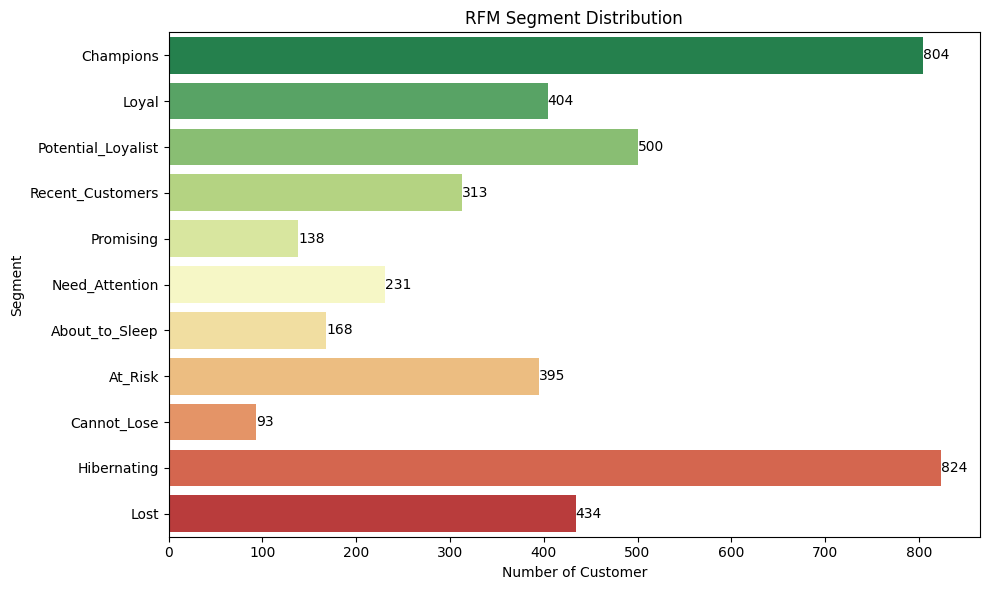

In [ ]:
rfm = analyze_customers(df)
segment_distribution = rfm['Segment'].value_counts().reset_index()
segment_distribution.columns = ['Segment', 'Number of Customer']

segment_order = [
    "Champions", "Loyal", "Potential_Loyalist", "Recent_Customers",
    "Promising", "Need_Attention", "About_to_Sleep", "At_Risk",
    "Cannot_Lose", "Hibernating", "Lost"
]

colors = sns.color_palette("RdYlGn", n_colors=len(segment_order))[::-1]
color_map = {segment: colors[i] for i, segment in enumerate(segment_order)}

plt.figure(figsize=(10, 6))
sns.barplot(
    data=segment_distribution,
    x="Number of Customer",
    y="Segment", hue='Segment',
    order=segment_order,
    palette=color_map, legend=False
)

plt.title("RFM Segment Distribution")
plt.xlabel("Number of Customer")
plt.ylabel("Segment")
for i, bar in enumerate(plt.gca().patches):
    value = bar.get_width()
    plt.text(
        value,
        bar.get_y() + bar.get_height() / 2,
        f"{value:.0f}",
        va='center',
        ha='left',
        fontsize=10
    )
plt.tight_layout()
plt.show()

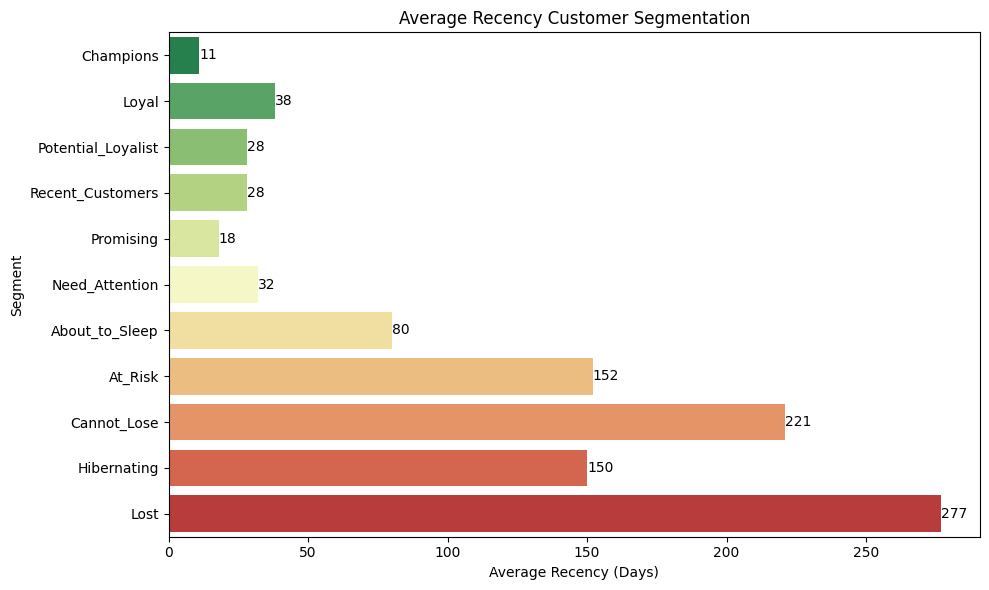

In [ ]:
avg_r = (rfm.groupby('Segment').agg({'Recency': 'mean'}).round(0)).reset_index()
avg_r.columns = ["Segment", "Average Recency (Days)"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_r,
    x="Average Recency (Days)",
    y="Segment",
    hue = "Segment",
    order=segment_order,
    palette=color_map, legend=False
)

plt.title("Average Recency Customer Segmentation")
plt.xlabel("Average Recency (Days)")
plt.ylabel("Segment")
for i, bar in enumerate(plt.gca().patches):
    value = bar.get_width()
    plt.text(
        value,
        bar.get_y() + bar.get_height() / 2,
        f"{value:.0f}",
        va='center',
        ha='left',
        fontsize=10
    )
plt.tight_layout()
plt.show()

In [ ]:
df_r = rfm.groupby("R_Score", observed=False).agg({'Recency':'mean'}).sort_values(by="R_Score").reset_index().rename(columns={'Recency': 'Avg_R_Value'})
df_f = rfm.groupby("F_Score", observed=False).agg({'Frequency':'mean'}).sort_values(by="F_Score").reset_index().rename(columns={'Frequency': 'Avg_F_Value'})
df_m = rfm.groupby("M_Score", observed=False).agg({'Monetary':'mean'}).sort_values(by="M_Score",).reset_index().rename(columns={'Monetary': 'Avg_M_Value'})

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[
        "Avg. R Value by R Score",
        "Avg. F Value by F Score",
        "Avg. M Value by M Score"])

fig.add_trace(
    go.Bar(x=df_r['R_Score'], y=df_r['Avg_R_Value'], marker_color='olive', name="Avg_R_Value"),
    row=1, col=1)

fig.add_trace(
    go.Bar(x=df_f['F_Score'], y=df_f['Avg_F_Value'], marker_color='teal', name="Avg. F Value"),
    row=1, col=2)

fig.add_trace(
    go.Bar(x=df_m['M_Score'], y=df_m['Avg_M_Value'], marker_color='purple', name="Avg. M Value"),
    row=1, col=3)

fig.update_layout(
    height=400, width=1200,
    title_text="RFM Metrics",
    showlegend=False)
fig.show()

In [ ]:
total_revenue = rfm.reset_index().groupby("Segment", observed=False).agg({"Monetary":"sum", "Recency":"mean", "CustomerID":"count"}).reset_index()
fig = px.scatter(
    total_revenue,
    x="Recency",
    y="Monetary",
    size="CustomerID",
    color="Segment",
    hover_name="Segment",
    title="Recency and Monetary of each Segment",
    labels={"Recency": "AVG Days Since Last Transaction",
            "Monetary": "Total Revenue"})
fig.update_layout(
    xaxis_title="AVG Days Since Last Transaction",
    yaxis_title="Total Revenue",
    legend_title="Segment",
    title_font_size=16)
fig.show()

#### Insights and Recommendation

In [ ]:
from IPython.display import display, HTML
segments_df = pd.DataFrame({
    'Segment': [
        'Champions',
        'Loyal Customers',
        'Potential Loyalists',
        'Recent Customers',
        'Promising Customers',
        'Needing Attention',
        'About to Sleep',
        'At Risk',
        "Can't Lose Them",
        'Hibernating',
        'Lost'],
    'Description': [
        'High-value frequent buyers',
        'Regular consistent buyers',
        'Promising new customers',
        'New accounts',
        'Small initial purchases',
        'Declining activity',
        'Reducing purchase frequency',
        'Previously high-value, now declining',
        'Former top accounts',
        'Long-inactive accounts',
        'No recent activity'],
    'Recommended Strategy': [
        'VIP wholesale program or loyalty program for online shopping',
        'Wholesale bundles like Christmas Gift/Thanks-giving season, volume-based benefits, premium services',
        'Trade credit options, graduated discounts, loyalty program promotions',
        'Welcome pack, sample products',
        'Starter packs to order, merchandising tips, easy reorder process',
        'Comeback discounts, reorder reminders',
        'Customer survey about our product',
        'Account review meetings, flexible payments, custom assortments',
        'Special pricing',
        'New product updates, restart packages like new-member, re-engagement',
        'Annual reactivation campaigns to their email, keep in promotional database'
    ]
})

styled_df = segments_df.style.hide(axis='index').set_properties(**{
    'padding': '10px',
    'text-align': 'left'
})

display(styled_df)

Segment,Description,Recommended Strategy
Champions,High-value frequent buyers,VIP wholesale program or loyalty program for online shopping
Loyal Customers,Regular consistent buyers,"Wholesale bundles like Christmas Gift/Thanks-giving season, volume-based benefits, premium services"
Potential Loyalists,Promising new customers,"Trade credit options, graduated discounts, loyalty program promotions"
Recent Customers,New accounts,"Welcome pack, sample products"
Promising Customers,Small initial purchases,"Starter packs to order, merchandising tips, easy reorder process"
Needing Attention,Declining activity,"Comeback discounts, reorder reminders"
About to Sleep,Reducing purchase frequency,Customer survey about our product
At Risk,"Previously high-value, now declining","Account review meetings, flexible payments, custom assortments"
Can't Lose Them,Former top accounts,Special pricing
Hibernating,Long-inactive accounts,"New product updates, restart packages like new-member, re-engagement"


### Seasonality Sales Behaviour Analysis

In [ ]:
monthly_sales = df.groupby(['Year', 'Month'], observed=False).agg({"Revenue":"sum", "CustomerID":"count"}).reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(DAY=1))
monthly_sales = monthly_sales[monthly_sales["Date"]!= "2011-12-01"]

fig = px.bar(monthly_sales,
             x='Date', y='Revenue', color='Revenue',
             color_continuous_scale = 'Teal', title="Total Revenue per Month")

fig.update(layout_coloraxis_showscale=False,)
fig.show()

fig = px.bar(monthly_sales,
             x='Date', y='CustomerID', color='CustomerID',
             color_continuous_scale = 'Teal', title="Number of Customer per Month")

fig.update(layout_coloraxis_showscale=False)
fig.show()

*  Monthly sales and the number of buyers showed a sharp increase between September 2011 and November 2011 which are near to the holiday season. Maintain a good application system will be good to handle the large amount of customers in this peak season.
*  While the outlook appears positive, longer-term data is needed to determine whether this trend is driven by winter seasonality or reflects an overall improvement in performance.

### Product Analysis

In [ ]:
product_performance = df.groupby('Description').agg({
        'Quantity': 'sum',
        'Revenue': 'sum',
        'CustomerID': 'nunique'
    }).rename(columns={'CustomerID': 'Unique_Customers'})
product_performance = product_performance.sort_values(by="Quantity", ascending=False).head(5).reset_index()

fig = px.bar(product_performance,
             x='Quantity', y='Description', color='Quantity',
             color_continuous_scale = 'Teal', title="Top 5 the Most Ordered Product")

fig.update(layout_coloraxis_showscale=False)
fig.show()

To increase more the product selling, it can be conducted with programs like product bundling or cross-selling product to suggest related product to customer. It can be do with Apriori Algorithm

In [ ]:
def basket_analysis(df):
    basket = (
        df.groupby(['InvoiceNo', 'Description'])['Quantity']
        .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
    )

    basket = basket > 0

    # apply Apriori Algorithm
    frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1, num_itemsets=len(frequent_itemsets))

    rules = rules.sort_values('lift', ascending=False)
    return rules

In [ ]:
rules = basket_analysis(df)
rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5)
styled_df = rules.style.hide(axis='index').set_properties(**{
    'padding': '10px',
    'text-align': 'left',
})

display(styled_df)

antecedents,consequents,support,confidence,lift
frozenset({'PINK REGENCY TEACUP AND SAUCER'}),"frozenset({'ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER'})",0.021045,0.701439,24.027846
"frozenset({'ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER'})",frozenset({'PINK REGENCY TEACUP AND SAUCER'}),0.021045,0.720887,24.027846
frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),"frozenset({'ROSES REGENCY TEACUP AND SAUCER ', 'PINK REGENCY TEACUP AND SAUCER'})",0.021045,0.564399,23.989564
"frozenset({'ROSES REGENCY TEACUP AND SAUCER ', 'PINK REGENCY TEACUP AND SAUCER'})",frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),0.021045,0.894495,23.989564
frozenset({'PINK REGENCY TEACUP AND SAUCER'}),frozenset({'GREEN REGENCY TEACUP AND SAUCER'}),0.024822,0.827338,22.188466


Metrics:

* Antecedents: Items that trigger the rule.
* Consequents: Items that are likely to be purchased together with the antecedents.
* Support: The frequency of the itemsets in the dataset.
* Confidence: The likelihood of purchasing the consequents when the antecedents are bought.
* Lift: The strength of the association between antecedents and consequents.

From the sample of product bundling or cross-selling:
70% of customers who buy 'PINK REGENCY TEACUP AND SAUCER' also buy 'ROSES REGENCY TEACUP AND SAUCER' and 'GREEN REGENCY TEACUP AND SAUCER'.

This suggests offering discounts for bundling these products or promoting this pair in marketing emails.

It would be even better to promote the least-ordered products by upselling them through product bundling or discounts.